# Preparation

### Import, constants and functions

In [ ]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [ ]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [ ]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/train_dataset.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data/test_dataset.npy', 'rb') as f:
    test_dataset = np.load(f)

In [ ]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [ ]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    4310 samples
Test set:     1437 samples
Sample dims:  (4310, 54, 96, 3)


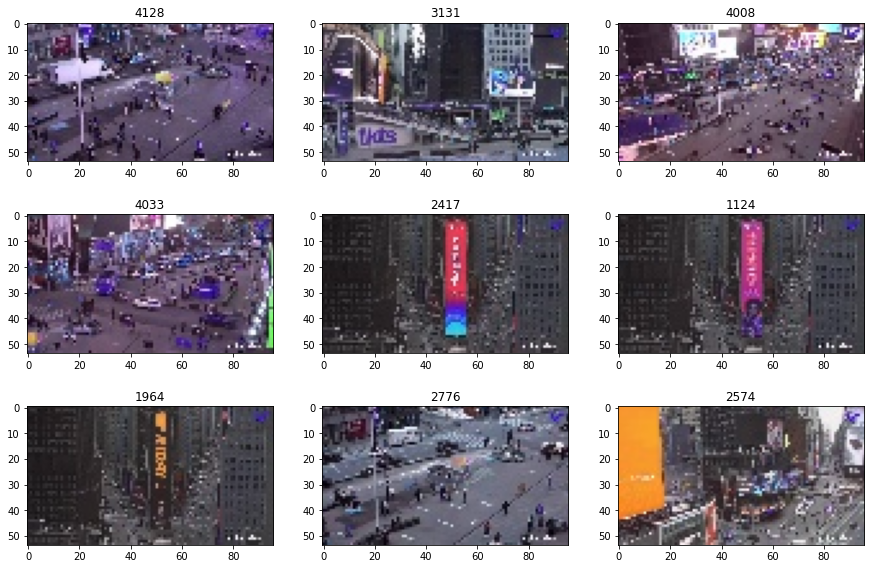

In [ ]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [ ]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Create model

In [ ]:
latent_dim = 1000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(254, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([        
        layers.Dense(width*hight*3, activation='sigmoid'),
        layers.Reshape((hight, width, 3)),
        layers.Conv2DTranspose(254, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", padding='same'),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, kernel_size=(1, 1), activation="relu", padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

In [ ]:
epochs = 10
batch_size = 16
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/10
270/270 [==============================] - 707s 3s/step - loss: 0.0433 - accuracy: 0.5944 - val_loss: 0.0312 - val_accuracy: 0.5087
Epoch 2/10
270/270 [==============================] - 714s 3s/step - loss: 0.0238 - accuracy: 0.6156 - val_loss: 0.0140 - val_accuracy: 0.6641
Epoch 3/10
270/270 [==============================] - 699s 3s/step - loss: 0.0126 - accuracy: 0.6312 - val_loss: 0.0111 - val_accuracy: 0.6787
Epoch 4/10
270/270 [==============================] - 697s 3s/step - loss: 0.0108 - accuracy: 0.6651 - val_loss: 0.0083 - val_accuracy: 0.7024
Epoch 5/10
270/270 [==============================] - 696s 3s/step - loss: 0.0081 - accuracy: 0.6824 - val_loss: 0.0076 - val_accuracy: 0.7347
Epoch 6/10
270/270 [==============================] - 700s 3s/step - loss: 0.0076 - accuracy: 0.7211 - val_loss: 0.0072 - val_accuracy: 0.7490
Epoch 7/10
270/270 [==============================] - 693s 3s/step - loss: 0.0071 - accuracy: 0.7305 - val_loss: 0.0073 - val_accuracy: 0.7318

Train Acc      0.7527129054069519
Validation Acc 0.737539529800415


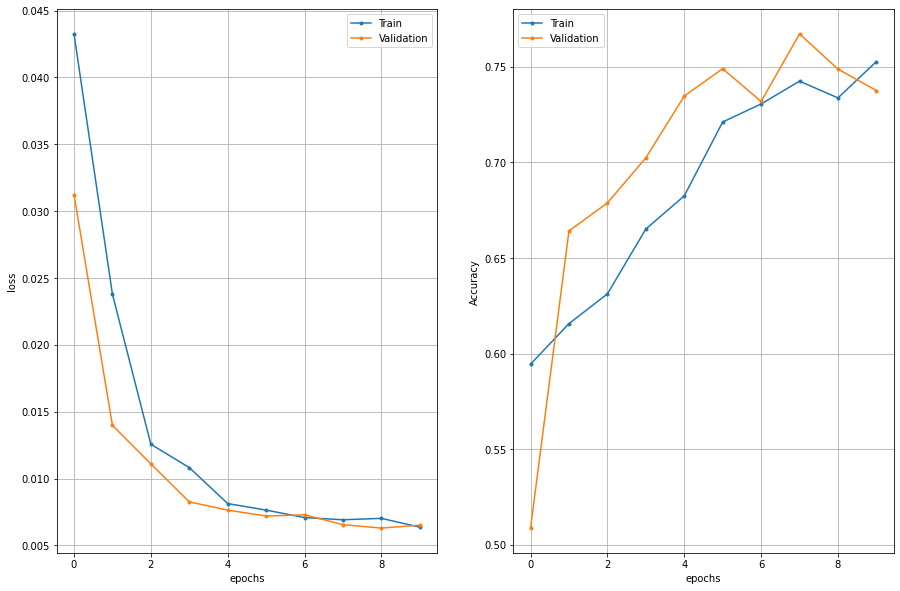

In [ ]:
show_results(history)

In [ ]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
    np.save(f, encoded_imgs)

In [ ]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (1437, 1000)
Sample decoded:  (1437, 54, 96, 3)
comression:  15.552


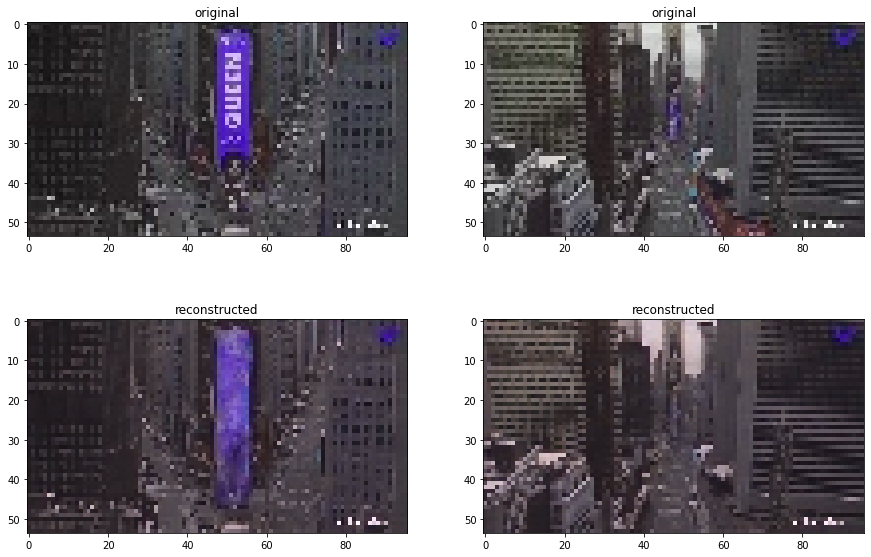

In [ ]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)

In [ ]:
autoencoder.summary()

Model: "autoencoder_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 1000)              18657510  
                                                                 
 sequential_11 (Sequential)  (None, 54, 96, 3)         15941387  
                                                                 
Total params: 34,598,897
Trainable params: 34,598,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.encoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, None, None, 64)    1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 128)   73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, None, None, 128)  0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 254)   292862    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, None, None, 254)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 15552)             15567552  
                                                                 
 reshape_5 (Reshape)         (None, 54, 96, 3)         0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 54, 96, 254)      7112      
 Transpose)                                                      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 54, 96, 254)       0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 54, 96, 128)      292736    
 Transpose)                                                      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 54, 96, 128)     